# Case Study: recalibration

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

plt.rcParams.update({
    'font.size': 8,
    'font.family': 'Times New Roman',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
})

In [2]:
def create_relative_change_df(calibrated_data, noncal_data, reference_index, reference_columns):
    df = pd.DataFrame(index=noncal_data.index, columns=noncal_data.columns)
    for col in df.columns:
        if col == 'PICP':
            df[col] = (abs(calibrated_data[col] - 0.95) - abs(noncal_data[col] - 0.95)) * 100
        else:
            df[col] = ((calibrated_data[col] - noncal_data[col]) / abs(noncal_data[col]) * 100)

    # Ensure identical order
    df = df.loc[reference_index, reference_columns]

    return df

In [3]:
data = pd.read_excel(os.path.join(os.getcwd(), 'results','synthetic_and_real1','metrics_.xlsx'),index_col=0)
data = data[~data["name"].str.contains("noise_0_")]

new_column_names = {
    'rmse': 'RMSE',
    'sharpness_std': 'Sharpness',
    'nll': 'NLL',
    'crps': 'CRPS',
    'interval': 'IS',
    'pinball': 'Pinball',
    'cal_score': 'CalS',
    'ecpe': 'ECPE',
    'qce': 'QCE',
    'picp': 'PICP',
    'cwc': 'CWC',
    'ence': 'ENCE',
    'uce': 'UCE'
}

new_data_names = {
    'forest_fires': '1',
    'facebook_metrics': '2',
    'computer_hardware': '3',
    'abalone': '4',
    'winequality': '5',
    'airfoil_self_noise': '6',
    'superconductivity_data': '7',
    'grid_stability': '8',
    'servo': '9',
    'concrete_compressive_strength': '10',
    'steel_industry': '11',
    'combined_cycle_power_plant': '12',
    'parkinson': '13',
    'auction_verification': '14',
    'energy_efficiency': '15',
    'age_prediction': '16'
}

data = data[data['n_run'] == 0]
data = data[list(new_column_names.keys()) + ['name', 'calibration']]
data = data.sort_values(by = 'rmse', axis = 0)

data_set_name = data['name'].unique()
data.rename(columns=new_column_names, inplace=True)
data['name'] = data['name'].map(new_data_names).fillna(data['name']).astype(str)

metrics = list(new_column_names.values())

cal_groups = data.groupby('calibration')

noncal_data = cal_groups.get_group('none')
noncal_data = noncal_data.set_index('name')
noncal_data = noncal_data.drop('calibration', axis='columns')

isotonic_data = cal_groups.get_group('isotonic')
isotonic_data = isotonic_data.set_index('name')
isotonic_data = isotonic_data.drop('calibration', axis='columns')

variance_data = cal_groups.get_group('variance')
variance_data = variance_data.set_index('name')
variance_data = variance_data.drop('calibration', axis='columns')

gpnormal_data = cal_groups.get_group('gpnormal')
gpnormal_data = gpnormal_data.set_index('name')
gpnormal_data = gpnormal_data.drop('calibration', axis='columns')

gpbeta_data = cal_groups.get_group('gpbeta')
gpbeta_data = gpbeta_data.set_index('name')
gpbeta_data = gpbeta_data.drop('calibration', axis='columns')

In [4]:
percent_threshold = 3

relative_change_df = pd.DataFrame(index=noncal_data.index, columns= noncal_data.columns)
for col in relative_change_df.columns:
    if col == 'PICP':
        relative_change_df[col] = (abs(isotonic_data[col] - 0.95) - abs(noncal_data[col] - 0.95))*100 # absolute distance to confidence level. If negative, then the distance has been reduced by the calibration
    else:
        relative_change_df[col] = ((isotonic_data[col] - noncal_data[col]) / abs(noncal_data[col]) *100)
# Function to apply style
def color_map(x):
    return np.where(x < -percent_threshold, 'background-color: #1f77b4',
           np.where(x > percent_threshold, 'background-color: #ff7f0e', ''))


# Apply the style
styled_df = relative_change_df.T.style.map(color_map).format(precision=2)
styled_df

name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
RMSE,0.93,0.03,-0.63,0.01,-0.02,0.04,-0.00,0.00,1.00,0.02,0.04,0.01,-0.00,-0.00,0.06,0.02
Sharpness,-79.64,-35.91,-42.35,-4.37,-1.64,-0.46,-2.33,-3.53,-15.82,-3.02,-5.46,-2.54,0.28,-2.15,-4.37,-2.61
NLL,-34.35,-1.25,25.87,-0.12,-0.09,-0.02,-0.17,-0.50,3.04,-0.45,-1.65,-0.61,-0.02,1.45,-1.22,-0.26
CRPS,-56.55,-10.89,-14.37,-0.41,-0.02,0.08,-0.01,0.12,-2.08,0.06,-0.11,0.12,0.00,-0.06,0.21,0.13
IS,-50.34,-0.00,-0.60,0.49,-0.08,-0.06,-0.03,-0.37,2.03,-0.08,0.13,-0.25,0.02,0.16,-0.34,-0.27
Pinball,-77.26,-21.22,-17.80,-0.86,1.18,-0.07,0.62,0.50,6.10,0.06,0.74,0.66,-0.04,-0.50,1.51,0.77
CalS,-91.16,-72.72,-70.85,-23.33,28.34,30.73,11.39,68.99,3.25,152.49,-2.07,19.64,-4.14,4.36,0.69,15.50
ECPE,-69.34,-49.62,-48.00,-9.61,11.75,25.64,3.33,35.13,15.38,72.46,-2.75,14.45,-2.65,2.15,0.00,7.25
QCE,-71.18,-50.38,-45.14,-5.31,5.76,16.48,-0.97,25.00,20.00,31.78,3.22,9.85,-0.00,-2.73,1.80,3.88
PICP,-3.51,0.81,4.52,0.16,0.62,-0.22,-0.32,-0.40,12.00,-0.33,1.16,-0.42,-0.11,0.34,-0.88,0.00


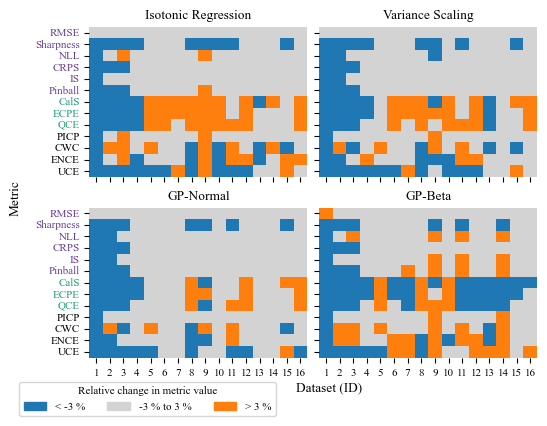

In [5]:
# Define consistent order based on noncal_data
reference_index = noncal_data.index
reference_columns = noncal_data.columns

# Sort noncal_data once
noncal_data_sorted = noncal_data.loc[reference_index, reference_columns]

# Create relative change DataFrames
relative_change_df1 = create_relative_change_df(isotonic_data, noncal_data_sorted, reference_index, reference_columns)
relative_change_df2 = create_relative_change_df(variance_data, noncal_data_sorted, reference_index, reference_columns)
relative_change_df3 = create_relative_change_df(gpnormal_data, noncal_data_sorted, reference_index, reference_columns)
relative_change_df4 = create_relative_change_df(gpbeta_data, noncal_data_sorted, reference_index, reference_columns)

# Custom 3-color colormap
color_below = list(mcolors.TABLEAU_COLORS.values())[0]
color_between = "lightgrey"
color_above = list(mcolors.TABLEAU_COLORS.values())[1]
cmap = ListedColormap([color_below, color_between, color_above])

# Dictionary of dataframes for easy looping
dfs = {
    "Isotonic Regression": relative_change_df1,
    "Variance Scaling": relative_change_df2,
    "GP-Normal": relative_change_df3,
    "GP-Beta": relative_change_df4,
}


# Custom groupings (by index)
group_1 = ['RMSE', 'Sharpness', 'NLL', 'CRPS', 'IS', 'Pinball']       # Red
group_2 = ['CalS', 'ECPE', 'QCE']    # Green

# Color mapping for each group
group_colors = {
    'group_1': '#6a3d9a',  # deep purple
    'group_2': '#1b9e77',  # teal green
}
label_to_color = {}
for label in group_1:
    label_to_color[label] = group_colors['group_1']
for label in group_2:
    label_to_color[label] = group_colors['group_2']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(5.5,4), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each heatmap
for ax, (title, df) in zip(axes, dfs.items()):
    categorized = df.T.copy()
    categorized[df.T < - percent_threshold] = -1
    categorized[(df.T >= -percent_threshold) & (df.T <= percent_threshold)] = 0
    categorized[df.T > percent_threshold] = 1

    sns.heatmap(categorized, cmap=cmap, cbar=False, linewidths=0.0,
                xticklabels=True, yticklabels=True, ax=ax, vmin=-1, vmax=1)
    ax.set_xlabel('')
    ax.set_title(title)

    # Apply colors to x-axis tick labels
    for tick in ax.get_yticklabels():
        label_text = tick.get_text()
        tick.set_color(label_to_color.get(label_text, 'black'))  # default to black
# Create a shared legend
legend_patches = [
    mpatches.Patch(color=color_below, label=f"< {-percent_threshold} %"),
    mpatches.Patch(color=color_between, label=f"{-percent_threshold} % to {percent_threshold} %"),
    mpatches.Patch(color=color_above, label=f"> {percent_threshold} %")
]
fig.supxlabel('Dataset (ID)', x = 0.6)
fig.supylabel('Metric')
# Place the legend below all subplots
fig.legend(handles=legend_patches, title="Relative change in metric value", loc='lower center',
           ncol=3, bbox_to_anchor=(0.27, -0.06))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Leave space for the legend
plt.savefig("figures\\result_recalibration.pdf", format="pdf", bbox_inches="tight")